Phase 1 (Data Preparation)

⚠️ Before running, make sure you open this shared dataset link:
[Shared Dataset Link](https://drive.google.com/drive/folders/1qITcchaDUSl2Yn7b0Dzsp2UT_i9Qaevg?usp=sharing)

Then add it to your own Drive (Right-click → Add shortcut to Drive).


In [5]:
# Cell: mount drive & set base_dir
from google.colab import drive
import os, glob, json

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
BASE_DIR = "/content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled"

if not os.path.exists(BASE_DIR):
    raise FileNotFoundError(f"{BASE_DIR} not found. Check path in Drive.")
print("✅ Dataset found at:", BASE_DIR)


✅ Dataset found at: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled


In [7]:
# ==========================================
# Phase 1: Data Preparation - Imports
# ==========================================

# File & folder handling
import os
import glob
import random
from collections import Counter

# Image processing
import cv2
import numpy as np

# Data analysis & utilities
import pandas as pd
from tqdm import tqdm   # nice progress bar (pip install tqdm if missing)

# Visualization
import matplotlib.pyplot as plt



In [12]:
#  list people folders inside BASE_DIR
people = [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]
print("Number of people folders:", len(people))  # should be ~5749







Number of people folders: 5749


Total people: 5749
Total images: 13233
Average images per person: 2.301791615933206
Median images per person: 1.0
Total people: 5749
Total images: 13233
Average images per person: 2.301791615933206
Median images per person: 1.0


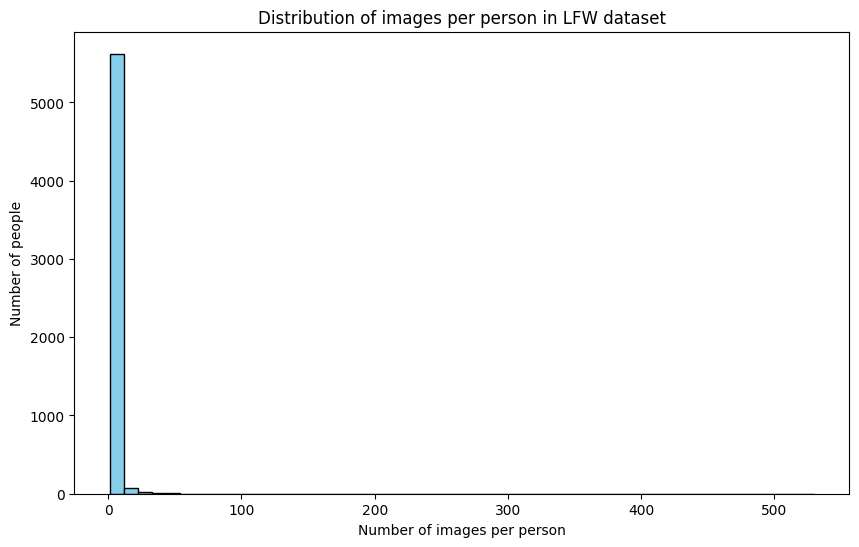

Top 10 people by number of images:
                 person  count
3121      George_W_Bush    530
4298       Colin_Powell    236
709          Tony_Blair    144
4644    Donald_Rumsfeld    121
3142  Gerhard_Schroeder    109
5370       Ariel_Sharon     77
3424        Hugo_Chavez     71
2191  Junichiro_Koizumi     60
3722      Jean_Chretien     55
3938      John_Ashcroft     53


In [18]:
#  count images per person
counts = {p: len(os.listdir(os.path.join(BASE_DIR, p))) for p in people}

counts_df = pd.DataFrame(list(counts.items()), columns=["person", "count"])

# Quick stats
print("Total people:", len(counts_df))
print("Total images:", counts_df["count"].sum())
print("Average images per person:", counts_df["count"].mean())
print("Median images per person:", counts_df["count"].median())

# Quick stats
print("Total people:", len(counts_df))
print("Total images:", counts_df["count"].sum())
print("Average images per person:", counts_df["count"].mean())
print("Median images per person:", counts_df["count"].median())




# Histogram

plt.figure(figsize=(10,6))
plt.hist(counts_df["count"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Number of images per person")
plt.ylabel("Number of people")
plt.title("Distribution of images per person in LFW dataset")
plt.show()



# Top 10 people by count
print("Top 10 people by number of images:")
print(counts_df.sort_values("count", ascending=False).head(10))


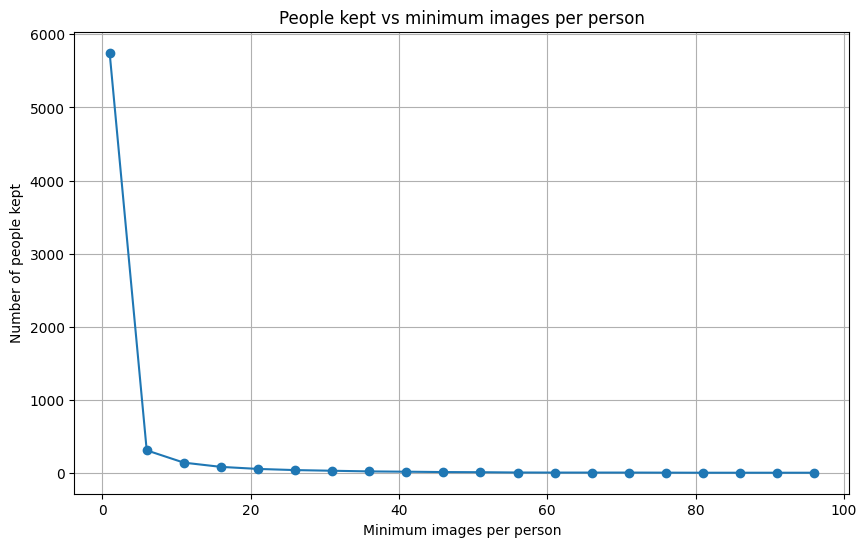

[(np.int64(1), np.int64(5749)),
 (np.int64(6), np.int64(311)),
 (np.int64(11), np.int64(143)),
 (np.int64(16), np.int64(85)),
 (np.int64(21), np.int64(57)),
 (np.int64(26), np.int64(41)),
 (np.int64(31), np.int64(32)),
 (np.int64(36), np.int64(23)),
 (np.int64(41), np.int64(19)),
 (np.int64(46), np.int64(14))]

In [19]:

thresholds = np.arange(1, 101, 5)  # from 1 to 100 in steps of 5
people_counts = [(t, (counts_df["count"] >= t).sum()) for t in thresholds]

# Plot
plt.figure(figsize=(10,6))
plt.plot([t for t, c in people_counts], [c for t, c in people_counts], marker="o")
plt.xlabel("Minimum images per person")
plt.ylabel("Number of people kept")
plt.title("People kept vs minimum images per person")
plt.grid(True)
plt.show()

# Show first few values
people_counts[:10]


In [20]:
MIN_IMAGES = 10  # our chosen cutoff

valid_people = counts_df[counts_df["count"] >= MIN_IMAGES]["person"].tolist()
print(f"Number of valid people (>= {MIN_IMAGES} images):", len(valid_people))


Number of valid people (>= 10 images): 158


In [21]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = (160, 160)

X, y = [], []

for person in tqdm(valid_people, desc="Loading subset"):
    folder = os.path.join(BASE_DIR, person)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path)
        if img is None:
            continue
        # Resize & normalize
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype("float32") / 255.0
        X.append(img)
        y.append(person)

X = np.array(X)
y = np.array(y)

print("✅ Subset loaded & preprocessed")
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique identities:", len(np.unique(y)))


Loading subset: 100%|██████████| 158/158 [13:47<00:00,  5.24s/it]


✅ Subset loaded & preprocessed
Images shape: (4324, 160, 160, 3)
Labels shape: (4324,)
Unique identities: 158


In [22]:
SAVE_DIR = "/content/drive/MyDrive/processed_lfw"
os.makedirs(SAVE_DIR, exist_ok=True)

np.save(os.path.join(SAVE_DIR, "X.npy"), X)
np.save(os.path.join(SAVE_DIR, "y.npy"), y)

print("✅ Saved X.npy and y.npy to:", SAVE_DIR)


✅ Saved X.npy and y.npy to: /content/drive/MyDrive/processed_lfw


George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64


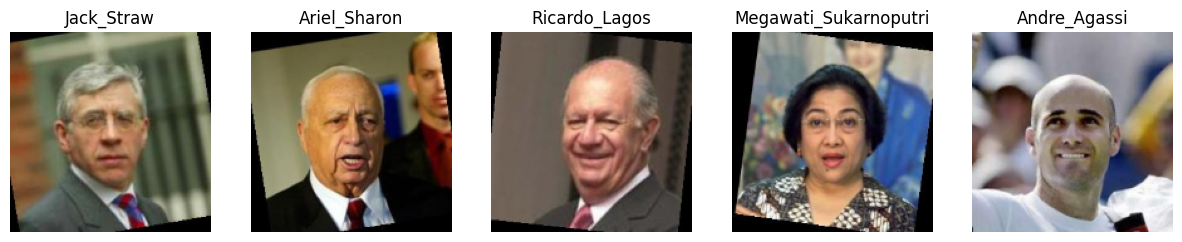

In [23]:
# Class distribution (top 10 people)
print(pd.Series(y).value_counts().head(10))

# Show 5 random images
fig, ax = plt.subplots(1, 5, figsize=(15,4))
for i in range(5):
    idx = random.randint(0, len(X)-1)
    ax[i].imshow(X[idx])
    ax[i].set_title(y[idx])
    ax[i].axis("off")
plt.show()
